In [1]:
import numpy as np
import pandas as pd
import pymongo
from dotenv import load_dotenv
from dotenv import dotenv_values
load_dotenv()  # read from .env file

config = dotenv_values(".env")  # get db pass word
client = pymongo.MongoClient(
    "mongodb+srv://miaroselentini:{}@cluster0.lgqqxmx.mongodb.net/?retryWrites=true&w=majority"\
        .format(config['MONGO_PASSWORD'])
)

# test connection
client.test

Database(MongoClient(host=['ac-s69hauj-shard-00-01.lgqqxmx.mongodb.net:27017', 'ac-s69hauj-shard-00-00.lgqqxmx.mongodb.net:27017', 'ac-s69hauj-shard-00-02.lgqqxmx.mongodb.net:27017'], document_class=dict, tz_aware=False, connect=True, retrywrites=True, w='majority', authsource='admin', replicaset='atlas-75kvw4-shard-0', tls=True), 'test')

# MovieLens 100K to Mongo DB

### Ratings

In [22]:
# read data and add column headers
rating_df = pd.read_csv('../RatingMatch/data/raw/ml-100k/u.data', sep='\t', header=None)
rating_df.columns = [x.strip() for x in 'user id | item id | rating | timestamp'.split('|')]

# keep only top 100 most popular movies
rating_df = rating_df[
    rating_df['item id'].isin(rating_df['item id'].value_counts().head(100).index)
]

# transform ratings 1, 2, 3 -> 0 to 4, 5 -=> 1
rating_df['rating'] = np.where(
    rating_df.rating >= 4, 1, 0
)

print('Average raw rating:', rating_df['rating'].mean())
print('Total ratings:', len(rating_df))
rating_df.head()

Average raw rating: 0.67004109451739
Total ratings: 29931


,user id,item id,rating,timestamp
1,186,302,0,891717742
6,115,265,0,881171488
10,62,257,0,879372434
12,200,222,1,876042340
22,299,144,1,877881320


### Users

In [24]:
user_df = pd.read_csv('../RatingMatch/data/raw/ml-100k/u.user', sep='|', header=None)
user_df.columns = [x.strip() for x in 'user id | age | gender | occupation | zip code'.split('|')]

user_df['decades_lived'] = (10 * np.floor((user_df.age / 10))).astype(int).astype(str)
user_df.drop(columns=['age', 'zip code'], inplace=True)

print(user_df.nunique())
user_df.head()

user id          943
gender             2
occupation        21
decades_lived      8
dtype: int64


,user id,gender,occupation,decades_lived
0,1,M,technician,20
1,2,F,other,50
2,3,M,writer,20
3,4,M,technician,20
4,5,F,other,30


In [26]:
item_df = pd.read_csv('../RatingMatch/data/raw/ml-100k/u.item', sep='|', header=None, encoding = "ISO-8859-1")

cols = """
    movie id | movie title | release date | video release date |
    IMDb URL | unknown | Action | Adventure | Animation |
    Children's | Comedy | Crime | Documentary | Drama | Fantasy |
    Film-Noir | Horror | Musical | Mystery | Romance | Sci-Fi |
    Thriller | War | Western 
"""
# update columns names of dataframe
item_df.columns = [x.strip() for x in cols.split('|')]

# replace date with decade of release
item_df['release_decade'] = [str(int(x)) if ~np.isnan(x) else np.nan for x in 10 * np.floor(pd.to_datetime(item_df['release date']).dt.year / 10)]

# drop date
item_df.drop(columns=['release date', 'video release date', 'IMDb URL', 'movie title'], inplace=True)

# reset dummies
item_df.set_index(['movie id'],inplace=True)
item_df = item_df[item_df==1].stack().reset_index().drop(0, axis=1)\
    .rename(columns={'level_1': 'genre'})\
    .merge(item_df['release_decade'], left_on='movie id', right_index=True, how='left')


print(item_df.nunique())
item_df.head()

movie id          1682
genre               19
release_decade       8
dtype: int64


,movie id,genre,release_decade
0,1,Animation,1990
1,1,Children's,1990
2,1,Comedy,1990
3,2,Action,1990
4,2,Adventure,1990


### Insert MovieLens 100K Dataframes into MongoDB

In [ ]:
db = client["movieLens"]

# insert rating data
collection = db["ratings"]
collection.insert_many(rating_df.to_dict(orient="records"))

# insert users
collection = db["users"]
collection.insert_many(user_df.to_dict(orient="records"))

# insert movies
collection = db["movies"]
collection.insert_many(item_df.to_dict(orient="records"))

In [31]:
print(client.list_database_names())
print(db.list_collection_names())

['movieLens', 'admin', 'local']
['movies', 'ratings', 'users']


### Fetch Data from MongoDB

In [4]:
db = client["movieLens"]

# read data from mongodb
query = {}
cursor = db["ratings"].find(query)
ratings = pd.DataFrame(list(cursor))

# users
cursor = db["users"].find(query)
users = pd.DataFrame(list(cursor))

# movies
cursor = db["movies"].find(query)
movies = pd.DataFrame(list(cursor))

### Wrangle Data and Make Visualizations

In [6]:
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

sns.set_style('darkgrid')

In [7]:
# merge data from mongoDB
data = ratings.drop('_id', axis=1).merge(users.drop('_id', axis=1), left_on='user id', right_on='user id', how='left').\
    merge(movies.drop('_id', axis=1), left_on='item id', right_on='movie id', how='left')

# convert timestamp integer to date
data['date'] = data['timestamp'].apply(lambda x: datetime.fromtimestamp(x)).dt.date

# set index
data.set_index(['user id', 'item id'], inplace=True)
data.head()

rating  timestamp gender occupation decades_lived  movie id  \
user id item id                                                                
186     302           0  891717742      F  executive            30       302   
        302           0  891717742      F  executive            30       302   
        302           0  891717742      F  executive            30       302   
        302           0  891717742      F  executive            30       302   
115     265           0  881171488      M   engineer            30       265   

                     genre release_decade        date  
user id item id                                        
186     302          Crime           1990  1998-04-04  
        302      Film-Noir           1990  1998-04-04  
        302        Mystery           1990  1998-04-04  
        302       Thriller           1990  1998-04-04  
115     265         Action           1990  1997-12-03

### Heatmap

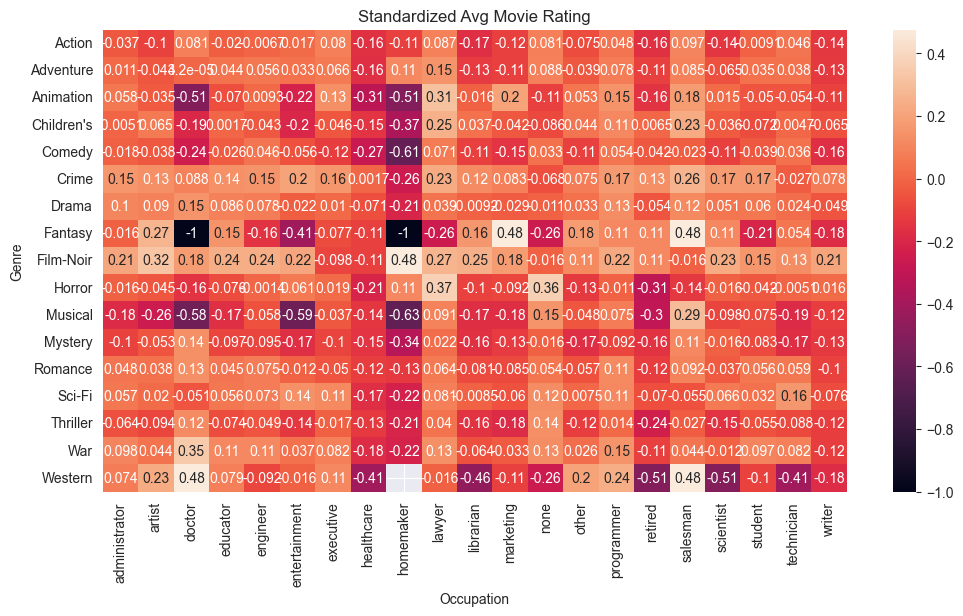

In [25]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.heatmap(
    (pd.pivot_table(
    data.drop('timestamp', axis=1),
        columns='occupation',
        index='genre',
        values='rating',
        aggfunc='mean'
    ) - data.rating.mean()) / data.rating.mean(),
    annot=True
)

plt.title('Standardized Avg Movie Rating')
plt.ylabel('Genre')
plt.xlabel('Occupation')
plt.show()

### Timeseries

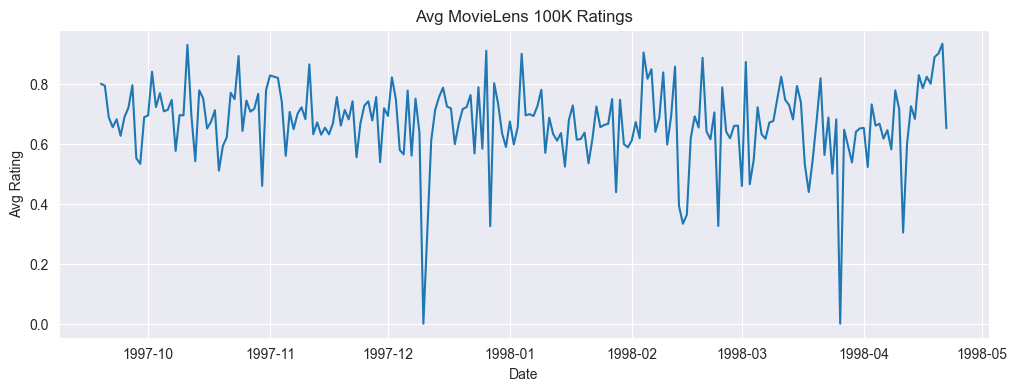

In [7]:
# number of ratings overtime
fig, ax = plt.subplots(figsize=(12, 4))
data.groupby('date').rating.mean().plot()

plt.title('Avg MovieLens 100K Ratings')
plt.ylabel('Avg Rating')
plt.xlabel('Date')
plt.show()

### Dimensionality Reduction and Clustering

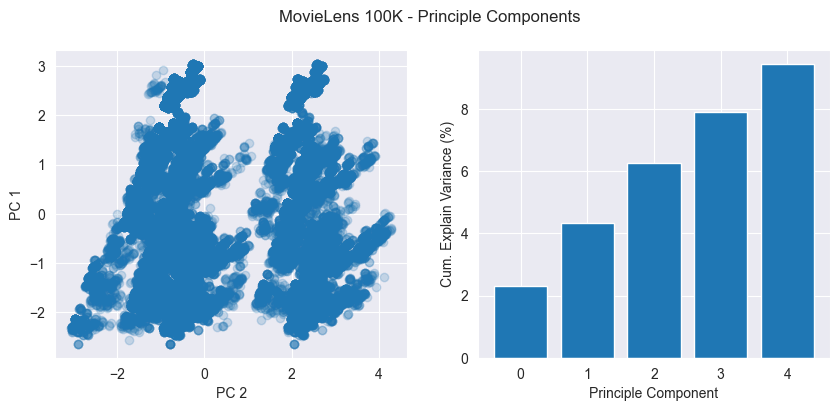

In [24]:
# get page visitor columns
data_dummies = pd.get_dummies(data.drop(['timestamp', 'date'], axis=1)).astype(int)

# get feature names
feature_names = data_dummies.columns

# standardize data
X = data_dummies.drop('rating', axis=1).to_numpy()
scaler = StandardScaler()
X = scaler.fit_transform(X)

# run 2d pca
K = 5
pca = PCA(n_components=K).fit(X)


results = pd.DataFrame([X.dot(pca.components_[0]), X.dot(pca.components_[1])]).T
results.columns = ['pc1', 'pc2']

results
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# make scatter plot in 2d
ax[0].scatter(results['pc1'], results['pc2'], alpha=0.1)
ax[1].bar(np.arange(K), pca.explained_variance_.cumsum())

ax[1].set_ylabel('Cum. Explain Variance (%)')
ax[1].set_xlabel('Principle Component')
ax[0].set_ylabel('PC 1')
ax[0].set_xlabel('PC 2')

plt.suptitle('MovieLens 100K - Principle Components')
plt.show()

### Kmeans Clustering

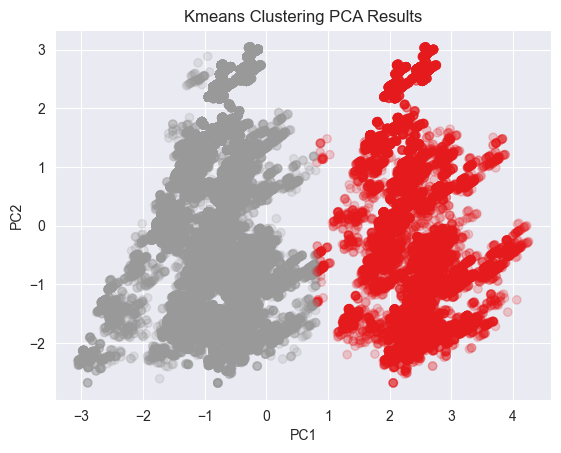

In [23]:
X = results[['pc1', 'pc2']]

# run kmeans clustering and replot scatter plot
kmeans = KMeans(n_clusters=2, init='random', random_state=2, n_init="auto").fit(X)

import matplotlib.cm as cm
plt.scatter(results['pc1'], results['pc2'], alpha=0.1, c=kmeans.labels_, cmap=cm.Set1)

plt.title('Kmeans Clustering PCA Results')
plt.ylabel('PC2')
plt.xlabel('PC1')

plt.show()